# ALT

### Import Modules

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, ShuffleSplit

from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyRegressor

### Import Prepared Data from kc_preprocessing_exploring.ipynb

We have already preprocessed our data in the kc_kc_preprocessing_exploring notebook:

[Preprocessing Notebook](./kc_preprocessing_exploring.ipynb)

In [2]:
df = pd.read_csv('./data/preprocessed_alt.csv', index_col = 0)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21532 entries, 0 to 21596
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   price           21532 non-null  float64
 1   sqft_living     21532 non-null  float64
 2   sqft_lot        21532 non-null  float64
 3   yr_built        21532 non-null  float64
 4   bedrooms        21532 non-null  float64
 5   bathrooms       21532 non-null  float64
 6   floors          21532 non-null  float64
 7   renovated_2000  21532 non-null  int64  
 8   waterfront      21532 non-null  int64  
 9   has_basement    21532 non-null  int64  
dtypes: float64(7), int64(3)
memory usage: 1.8 MB


In [4]:
subs = [(' ', '_'),('.','_'),("'",""),('™', ''), ('®',''),
        ('+','plus'), ('½','half'), ('-','_')
       ]
def col_formatting(col):
    for old, new in subs:
        col = col.replace(old,new)
    return col

df.columns = [col_formatting(col) for col in df.columns]

list(df.columns)

['price',
 'sqft_living',
 'sqft_lot',
 'yr_built',
 'bedrooms',
 'bathrooms',
 'floors',
 'renovated_2000',
 'waterfront',
 'has_basement']

## Split, Train and Test Data

Now that we have a complete preprocessed dataset, we need to split the data into train and test datasets, as well as identify the feature we are testing for: price.

In [5]:
X = df.drop(['price'], axis=1)
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

#check size of each
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((16149, 9), (5383, 9), (16149,), (5383,))

In [6]:
X_1 = X_train
y = y_train

model_1_orig = sm.OLS(y, sm.add_constant(X_1)).fit()
model_1_orig.summary()

C:\Users\moola\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.483
Model:                            OLS   Adj. R-squared:                  0.483
Method:                 Least Squares   F-statistic:                     1677.
Date:                Thu, 12 May 2022   Prob (F-statistic):               0.00
Time:                        19:38:55   Log-Likelihood:            -2.2447e+05
No. Observations:               16149   AIC:                         4.490e+05
Df Residuals:                   16139   BIC:                         4.490e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           5.338e+05   2897.166    184.256      0.000    5.28e+05    5.39e+05
sqft_living     2.542e+05   4101.627     61.986      0.000    2.46e+05    2.62e+05
sqft_lot       -1.525e+04   2567.890     -5.937      0.000   -2.03e+04   -1.02e+04
yr_built        -8.45e+04   2677.458    -31.559      0.000   -8.97e+04   -7.92e+04
bedrooms       -6.007e+04   2778.273    -21.622      0.000   -6.55e+04   -5.46e+04
bathrooms       3.325e+04   3805.913      8.737      0.000    2.58e+04    4.07e+04
floors          2.808e+04   3003.755      9.350      0.000    2.22e+04     3.4e+04
renovated_2000  1.107e+05   1.62e+04      6.837      0.000     7.9e+04    1.42e+05
waterfront      9.519e+05    2.5e+04     38.060      0.000    9.03e+05       1e+06
has_basement   -8307.4492   5202.750     -1.597      0.110   -1.85e+04    1890.518
==============================================================================
Omnibus:                    12860.582   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           850975.749
Skew:                           3.336   Prob(JB):                         0.00
Kurtosis:                      37.931   Cond. No.                         20.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Remove Uninfluential Features

The first issue with our model is the number of features. This much potential noise is likely not helping our model properly train itself on the relevant data.

As our first approach, we use scikit-learn's feature_selection submodule to select only the most important features.

In [7]:
# Importances are based on coefficient magnitude, so
# we need to scale the data to normalize the coefficients
X_train_for_RFECV = StandardScaler().fit_transform(X_train)

# Instantiate and fit the selector
selector = RFECV(LinearRegression(), cv=ShuffleSplit(n_splits=3, test_size=0.25, random_state=0))
selector.fit(X_train_for_RFECV, y_train)

selected_features = []

# Relevant Features:
for index, col in enumerate(X_train.columns):
    if selector.support_[index] == True:
        selected_features.append(col)
        #print(col)

print(selected_features)

['sqft_living', 'sqft_lot', 'yr_built', 'bedrooms', 'bathrooms', 'floors', 'renovated_2000', 'waterfront', 'has_basement']


No features were removed

### Investigate Multicollinearity

Cond No is NOT above 30, but nonetheless explore collinearity

In [9]:
corr = X_1.corr()
corr

,sqft_living,sqft_lot,yr_built,bedrooms,bathrooms,floors,renovated_2000,waterfront,has_basement
sqft_living,1.000000,0.328794,0.351948,0.652068,0.763292,0.396071,0.044469,0.085463,0.233090
sqft_lot,0.328794,1.000000,-0.006077,0.202972,0.087826,-0.214441,-0.008913,0.074727,-0.048784
yr_built,0.351948,-0.006077,1.000000,0.199792,0.534953,0.474481,-0.123900,-0.021563,-0.164290
bedrooms,0.652068,0.202972,0.199792,1.000000,0.540399,0.217331,0.034062,-0.006333,0.155752
bathrooms,0.763292,0.087826,0.534953,0.540399,1.000000,0.512944,0.057632,0.050733,0.167496
floors,0.396071,-0.214441,0.474481,0.217331,0.512944,1.000000,0.010760,0.020177,-0.256180
renovated_2000,0.044469,-0.008913,-0.123900,0.034062,0.057632,0.010760,1.000000,0.017132,0.047421
waterfront,0.085463,0.074727,-0.021563,-0.006333,0.050733,0.020177,0.017132,1.000000,0.039966
has_basement,0.233090,-0.048784,-0.164290,0.155752,0.167496,-0.256180,0.047421,0.039966,1.000000


In [10]:
sns.set(rc = {'figure.figsize':(20,20)})

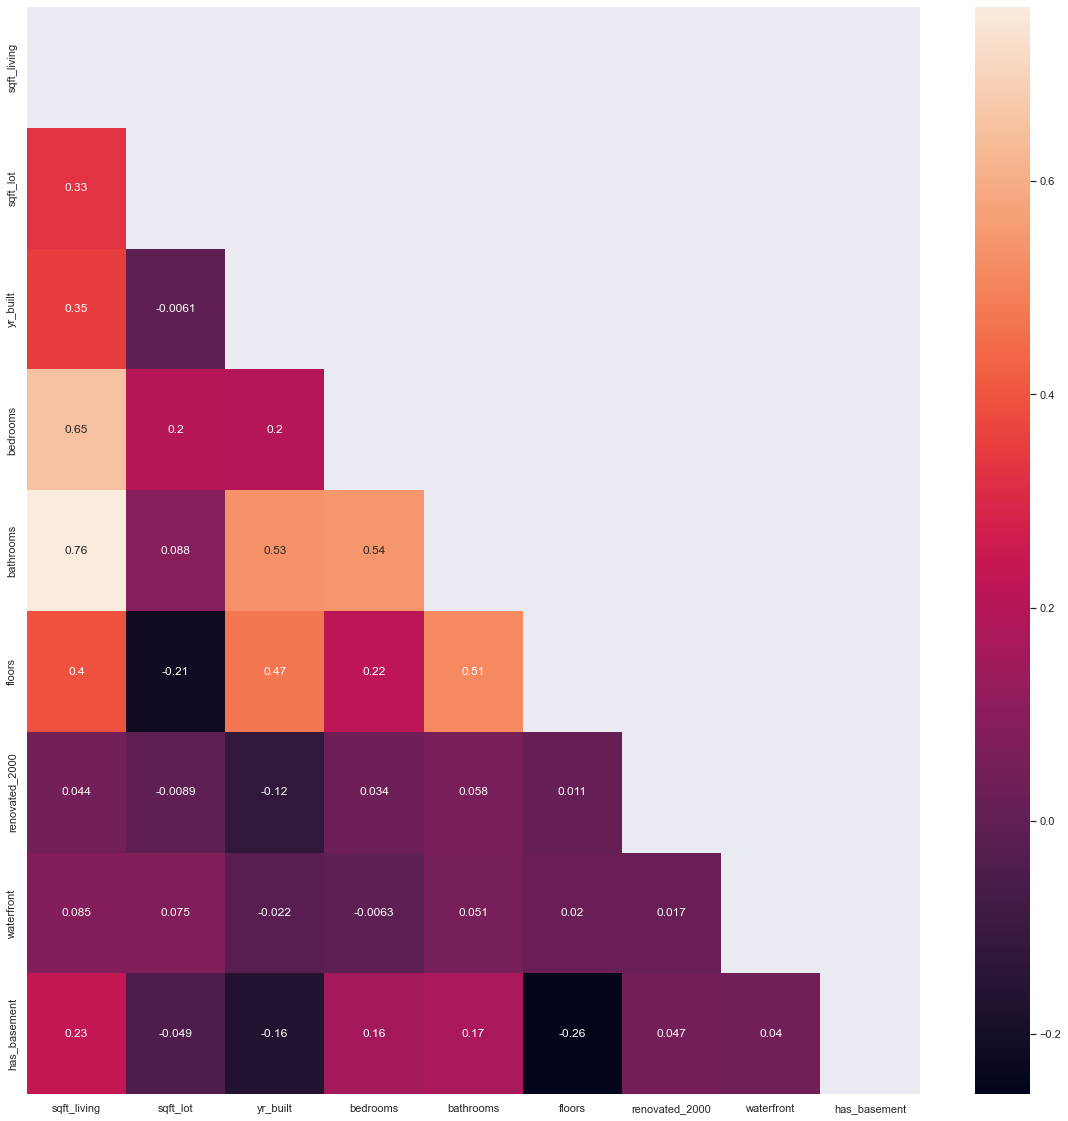

In [11]:
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, annot = True, mask=mask);

We still have far too many features to just visually identify which combinations are contributing the most to multicollinearity. 

In [12]:
#remove correlation of features with themselves
corr = corr[corr < 1]

#top positively correlated
corr[corr < 1].unstack().sort_values(ascending=False)[:20]

sqft_living   bathrooms       0.763292
bathrooms     sqft_living     0.763292
sqft_living   bedrooms        0.652068
bedrooms      sqft_living     0.652068
bathrooms     bedrooms        0.540399
bedrooms      bathrooms       0.540399
bathrooms     yr_built        0.534953
yr_built      bathrooms       0.534953
bathrooms     floors          0.512944
floors        bathrooms       0.512944
              yr_built        0.474481
yr_built      floors          0.474481
sqft_living   floors          0.396071
floors        sqft_living     0.396071
yr_built      sqft_living     0.351948
sqft_living   yr_built        0.351948
              sqft_lot        0.328794
sqft_lot      sqft_living     0.328794
sqft_living   has_basement    0.233090
has_basement  sqft_living     0.233090
dtype: float64

The above list of values shows the most positively correlated pairings of features. Ideally we would remove one of each of the features with the strongest collinearity.

We can see that things like bedrooms and sqftliving are strongly correlated. We can experiment with removing these features later, but for now we keep them because they are recognizable as potentially important features of the pricing of a home.

We want to remove features we see a many times, and can probably attempt to remove bathrooms, as they are a strongly correlated feature with both sqft_living and bedrooms, which makes sense in real-life terms as well (larger homes with more bedrooms are likely to have more bathrooms, etc). Similarly, we can try removing view_excellent because it seems to heavily correlate with being on a waterfront.

In [13]:
items_to_drop = ['bathrooms', 'floors']

In [14]:
#negatively correlated
corr.unstack().sort_values(ascending=True)[:20]

has_basement    floors           -0.256180
floors          has_basement     -0.256180
sqft_lot        floors           -0.214441
floors          sqft_lot         -0.214441
yr_built        has_basement     -0.164290
has_basement    yr_built         -0.164290
renovated_2000  yr_built         -0.123900
yr_built        renovated_2000   -0.123900
sqft_lot        has_basement     -0.048784
has_basement    sqft_lot         -0.048784
waterfront      yr_built         -0.021563
yr_built        waterfront       -0.021563
sqft_lot        renovated_2000   -0.008913
renovated_2000  sqft_lot         -0.008913
bedrooms        waterfront       -0.006333
waterfront      bedrooms         -0.006333
sqft_lot        yr_built         -0.006077
yr_built        sqft_lot         -0.006077
renovated_2000  floors            0.010760
floors          renovated_2000    0.010760
dtype: float64

None to remove

Now that we have checked for uninfluential features as well as features potentially causing multicollinearity, we run the tests again.

In [15]:
X_2 = X_1.drop(items_to_drop, axis=1)

model_2_remove_corr = sm.OLS(y, sm.add_constant(X_2)).fit()
model_2_remove_corr.rsquared

C:\Users\moola\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


0.47657485563589963

This decreased out our R-squared value, which is not necessarily a problem. We will try a few more things before we compare each model's RMSE.

Before comparing all of our models ability to accurately predict data on the training and testing sets, we will create a feature set based on our observations in the preprocessing phase and create a model for it as well. We will try removing the categorical variables as well.

We will look at the correlation between each feature and price from the preprocessed model as a guide.

In [16]:
#absolute values because negative correlation still counts
price_corr = abs(df.corr()['price']).sort_values(ascending = False)
price_corr

price             1.000000
sqft_living       0.612307
bathrooms         0.456159
bedrooms          0.298957
floors            0.266977
waterfront        0.259221
has_basement      0.177574
sqft_lot          0.161755
renovated_2000    0.106630
yr_built          0.053036
Name: price, dtype: float64

In [17]:
#just take the top correlated features with price
observed_features = price_corr.index[1:11]

X_4 = X_train[observed_features]

model_4_price_corr = sm.OLS(y, sm.add_constant(X_4)).fit()
model_4_price_corr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.483
Model:                            OLS   Adj. R-squared:                  0.483
Method:                 Least Squares   F-statistic:                     1677.
Date:                Thu, 12 May 2022   Prob (F-statistic):               0.00
Time:                        19:56:53   Log-Likelihood:            -2.2447e+05
No. Observations:               16149   AIC:                         4.490e+05
Df Residuals:                   16139   BIC:                         4.490e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           5.338e+05   2897.166    184.256      0.000    5.28e+05    5.39e+05
sqft_living     2.542e+05   4101.627     61.986      0.000    2.46e+05    2.62e+05
bathrooms       3.325e+04   3805.913      8.737      0.000    2.58e+04    4.07e+04
bedrooms       -6.007e+04   2778.273    -21.622      0.000   -6.55e+04   -5.46e+04
floors          2.808e+04   3003.755      9.350      0.000    2.22e+04     3.4e+04
waterfront      9.519e+05    2.5e+04     38.060      0.000    9.03e+05       1e+06
has_basement   -8307.4492   5202.750     -1.597      0.110   -1.85e+04    1890.518
sqft_lot       -1.525e+04   2567.890     -5.937      0.000   -2.03e+04   -1.02e+04
renovated_2000  1.107e+05   1.62e+04      6.837      0.000     7.9e+04    1.42e+05
yr_built        -8.45e+04   2677.458    -31.559      0.000   -8.97e+04   -7.92e+04
==============================================================================
Omnibus:                    12860.582   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           850975.749
Skew:                           3.336   Prob(JB):                         0.00
Kurtosis:                      37.931   Cond. No.                         20.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Evaluating Models
Next we will compare the RMSE for models from each set of features we explored, on both the training and testing data.

The RMSE, or Root Mean Squared Error, is a measure of how far off our regression models are from the actual values they attempt to predict. The lower the RMSE, the better at predicting prices the trained model is.

In [18]:
#training linear regression models on the training set for each set of features

#X_1
#train model
model1 = LinearRegression().fit(X_1, y_train)
#predict on model
pred1 = model1.predict(X_1)
#rmse for training set
train1_rmse = mean_squared_error(y_train, pred1, squared=False)

#create test set of features
X_1_test = X_test[X_1.columns]
#predict on test feature set
pred1_test = model1.predict(X_1_test)
#rmse for test set
test1_rmse = mean_squared_error(y_test, pred1_test, squared=False)

#X_2
model2 = LinearRegression().fit(X_2, y_train)
pred2 = model2.predict(X_2)
train2_rmse = mean_squared_error(y_train, pred2, squared=False)

X_2_test = X_test[X_2.columns]
pred2_test = model2.predict(X_2_test)
test2_rmse = mean_squared_error(y_test, pred2_test, squared=False)

#X_4
model4 = LinearRegression().fit(X_4, y_train)
pred4 = model4.predict(X_4)
train4_rmse = mean_squared_error(y_train, pred4, squared=False)

X_4_test = X_test[X_4.columns]
pred4_test = model4.predict(X_4_test)
test4_rmse = mean_squared_error(y_test, pred4_test, squared=False)


In [19]:
print('Model 1 - Original:')
print('  Training Data RMSE: ',train1_rmse)
print('  Test Data RMSE: ',test1_rmse)
print()
print('Model 2 - Removed Uninfluential:')
print('  Training Data RMSE: ',train2_rmse)
print('  Test Data RMSE: ',test2_rmse)

print()
print('Model 4 - Based On Observations:')
print('  Training Data RMSE: ',train4_rmse)
print('  Test Data RMSE: ',test4_rmse)


Model 1 - Original:
  Training Data RMSE:  263299.999277122
  Test Data RMSE:  270654.7615805127

Model 2 - Removed Uninfluential:
  Training Data RMSE:  264984.8430642421
  Test Data RMSE:  272478.83359948086

Model 4 - Based On Observations:
  Training Data RMSE:  263299.999277122
  Test Data RMSE:  270654.7615805126


While it is only by a small amount, our second model performed the best with the test data, at about a 213,708 RMSE. SO we will 

## Final Model Interpretation

In [23]:
final_model = model4
final_model.score(X_test_final, y_test)

0.4515794915334653

The final model's score indicates that it is accurate about 66% of the time.

Next we investigate if our model violates each of the assumptions of linear regression:

### Linearity

In [24]:
sns.set(rc = {'figure.figsize':(5,5)})

Text(0, 0.5, 'Predicted Value')

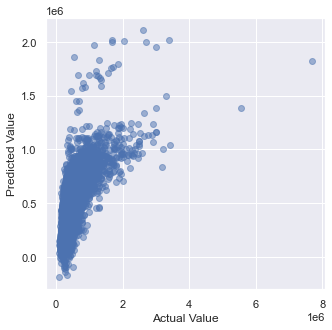

In [25]:
preds = final_model.predict(X_test_final)
fig, ax = plt.subplots()

perfect_line = np.arange(y_test.min(), y_test.max())
ax.scatter(y_test, preds, alpha=0.5)
ax.set_xlabel("Actual Value")
ax.set_ylabel("Predicted Value")

This actually looks like it has a decently linear relationship, with only a few noteable outliers.

### Normality

C:\Users\moola\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


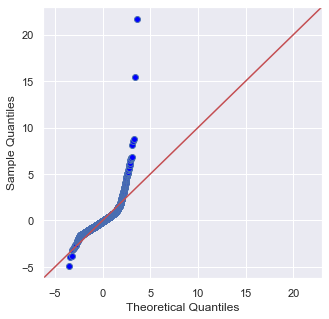

In [26]:
residuals = (y_test - preds)
sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True);

With the exception of some outliers, this plot does look relatively normal.

### Multicollinearity
We already made sure that our model did not violate multicollinearity by removing features in the modeling phase. But we check again in the interest of good practice.

In [27]:
vif = [variance_inflation_factor(X_train_final.values, i) for i in range(X_train_final.shape[1])]

pd.Series(vif, index=X_train_final.columns, name="Variance Inflation Factor")

sqft_living       3.773583
bathrooms         3.342469
bedrooms          1.793269
floors            1.903750
waterfront        1.025809
has_basement      1.268587
sqft_lot          1.460672
renovated_2000    1.046965
yr_built          1.631957
Name: Variance Inflation Factor, dtype: float64

### Homoscedasticity

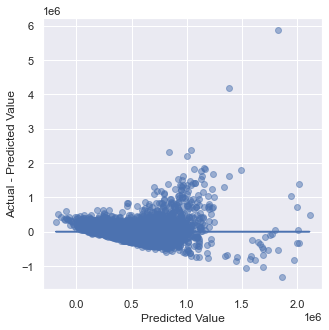

In [28]:
fig, ax = plt.subplots()

ax.scatter(preds, residuals, alpha=0.5)
ax.plot(preds, [0 for i in range(len(X_test_final))])
ax.set_xlabel("Predicted Value")
ax.set_ylabel("Actual - Predicted Value");

In [29]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

print(pd.Series(final_model.coef_, index=X_train_final.columns, name="Coefficients"))
print()
print("Intercept:", final_model.intercept_)

sqft_living      254241.893
bathrooms         33253.354
bedrooms         -60073.094
floors            28084.206
waterfront       951913.179
has_basement      -8307.449
sqft_lot         -15245.395
renovated_2000   110716.504
yr_built         -84497.205
Name: Coefficients, dtype: float64

Intercept: 533820.6756044596
